In [ ]:
# !pip install pyshp --user

In [1]:
from io import StringIO, BytesIO
from zipfile import ZipFile
import requests
import json
import shapefile as pyshp
import pixiedust
import numpy as np
from PIL import Image
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
%matplotlib inline

Pixiedust database opened successfully


In [2]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_6a1cd4de_5fda_4aed_9daa_77a16acbd0eb',
  'project_id':'90a4103b7b014ee9b3a296b606adfd2c',
  'region':'dallas',
  'user_id':'1bd2322937af414c89f34c0e4401966a',
  'domain_id':'41ca524ef22c4741810dc798e071edb9',
  'domain_name':'1446795',
  'username':'member_c49620b6c86f8fba9f62c285d31813a28ac52d11',
  'password':"""qR^35ffqgfOxvx_5""",
  'container':'Codebreakers',
}

# Função de leitura de arquivos do Object Storage
def get_file(filename, mode = 't'):
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}    
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    if mode == 'b':
        return BytesIO(resp2.content)
    elif mode == 't':
        return StringIO(resp2.text)
    else:
        raise ValueError('Mode nao reconhecido')

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
# data_1 = get_object_storage_file_with_credentials_6a1cd4de5fda4aed9daa77a16acbd0eb('Codebreakers', 'shapesZonaAzul.zip')

In [3]:
# Leitura dos arquivos
zf = ZipFile(get_file('shapesZonaAzul.zip', 'b'))
arqs_shp = ['ZonaAzulFaces', 'ZonaAzulVagas', 'ZonaAzulVagasNaoRotativas']
arquivos = []
for arq_shp in arqs_shp:
    shp = BytesIO(zf.open(arq_shp + '.shp').read())
    dbf = BytesIO(zf.open(arq_shp + '.dbf').read())
    shx = BytesIO(zf.open(arq_shp + '.shx').read())
    arquivos.append(pyshp.Reader(shp=shp, dbf=dbf, shx=shx))
faces, vagas, vagas_n_rotativas = arquivos
# field_names = [field[0] for field in sf.fields[1:]]
# sr = sf.shapeRecords()

In [ ]:
print(vagas.shapeRecords()[0].shape.points[0])
print(vagas.fields)

In [4]:
rows = []
for sr in vagas.iterShapeRecords():
    rows.append(pyspark.sql.Row(lat=sr.shape.points[0][1], lon=sr.shape.points[0][0], vagas=sr.record[3]))
df = sqlContext.createDataFrame(rows)

In [ ]:
display(df)

In [5]:
df.agg({"lat": "min", "lon": "min"}).collect()[0].asDict()

{'min(lat)': -23.668001009999998, 'min(lon)': -46.71286308}

In [6]:
df.agg({"lat": "max", "lon": "max"}).collect()[0].asDict()

{'max(lat)': -23.473188989999997, 'max(lon)': -46.411904879999994}

In [7]:
r = df.agg({"lat": "min", "lon": "min"}).collect()[0]
lat_min, lon_min = r['min(lat)'], r['min(lon)']

r = df.agg({"lat": "max", "lon": "max"}).collect()[0]
lat_max, lon_max = r['max(lat)'], r['max(lon)']

In [ ]:
print(lat_min, lat_max)
print(np.floor(lat_min), np.ceil(lat_max))

In [ ]:
print(lon_min, lon_max)
print(np.floor(lon_min), np.ceil(lon_max))

In [23]:
lat_min_min, lat_max_max = np.floor(lat_min), np.ceil(lat_max)
lon_min_min, lon_max_max = np.floor(lon_min), np.ceil(lon_max)

In [27]:
lat_min_min_broad = sc.broadcast(lat_min_min)
# lat_max_max_broad = sc.broadcast(lat_max_max)
lon_min_min_broad = sc.broadcast(lon_min_min)
# lon_max_max_broad = sc.broadcast(lon_max_max)

In [8]:
nx, ny = (1000, 1000)

In [9]:
x = np.linspace(lat_min_min, lat_max_max, nx)
y = np.linspace(lon_min_min, lon_max_max, ny)

In [10]:
xx, yy = np.meshgrid(x, y)

In [11]:
xx_broad = sc.broadcast(xx)
yy_broad = sc.broadcast(yy)

In [12]:
m = np.zeros((nx, ny))

for i in range(nx - 1):
    for j in range(ny - 1):
        x_bot, y_bot = xx[i, j], yy[i, j]
        x_up, y_up = xx[i + 1, j + 1], yy[i + 1, j + 1]

#         print(x_bot, y_bot)
#         print(x_up, y_up)
#         print(lon, lat)
#         print()

        for sr in vagas.iterShapeRecords():
            lat = sr.shape.points[0][1]
            lon = sr.shape.points[0][0]
            qtd_vagas = sr.record[3]

#             print(x_bot, lon, x_up)
#             print(y_bot, lat, y_up)
#             print()

            if (x_bot <= lon < x_up) and (y_bot <= lat < y_up):
#                 print('oi')
                m[i, j] += 1
#         break
        

In [77]:
m.max(), m.min()

(9.0, 0.0)

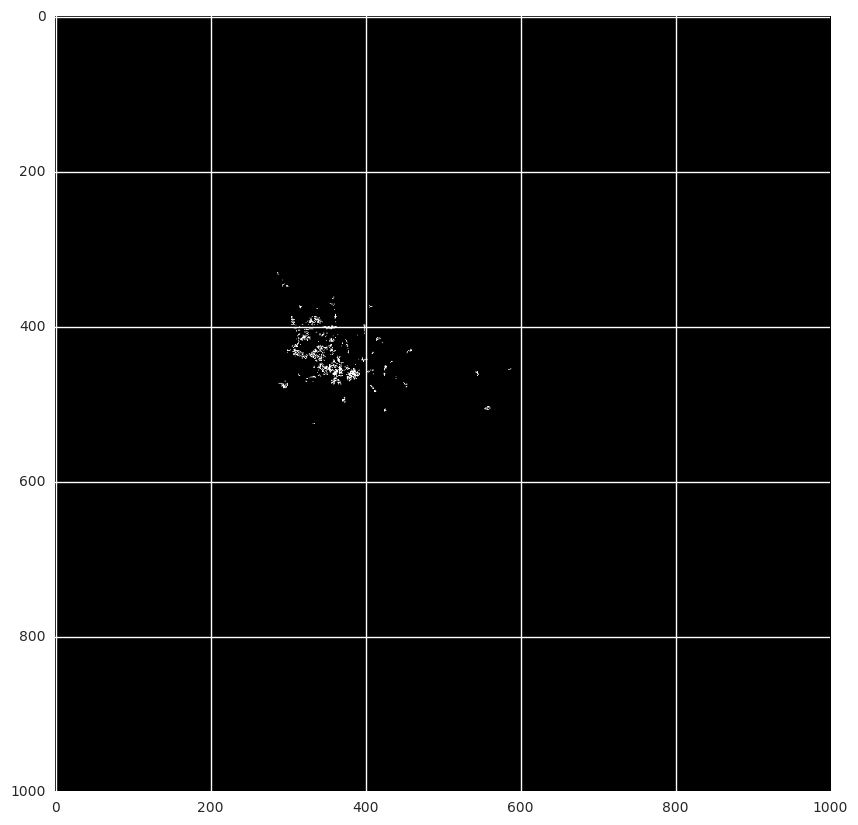

In [85]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(Image.fromarray(2550000*m/m.max())).set_cmap('binary')

In [ ]:
plt.imshow(Image.fromarray(50000000*m/m.max())).set_cmap

In [36]:
np.floor((-46.63 - lon_min_min_broad.value)/0.001).astype(int)

369

In [37]:
def f(lat, lon):
    a = np.floor((lat - lat_min_min_broad.value)/0.001).astype(int)
    b = np.floor((lon - lon_min_min_broad.value)/0.001).astype(int)
    for i in range(a - 1, nx - 1):
        for j in range(b - 1, ny - 1):
            x_bot, y_bot = xx[i, j], yy[i, j]
            x_up, y_up = xx[i + 1, j + 1], yy[i + 1, j + 1]
            if (x_bot <= lon < x_up) and (y_bot <= lat < y_up):
                return [i, j]
f_udf = udf(f)

In [14]:
a, b = vagas.shapeRecords()[0].shape.points[0]

In [15]:
print(a, b)

-46.630608839999994 -23.550047009999997


In [16]:
(a - (-47))/.001

369.3911600000064

In [17]:
x[369] <= a < x[370]

True

In [41]:
teste_df = df.withColumn("new_col", f_udf(df['lat'], df['lon']))

In [48]:
eval(teste_df.toPandas().loc[0]['new_col'])

[449, 369]

In [59]:
for row in teste_df.toPandas().iterrows():
    s, t = eval(row[1]['new_col'])
    m[s, t] += 1

In [67]:
m[400]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0